# Exploaracion de la data

In [1]:
import pandas as pd

## Cargamos los datos

In [2]:
import os
from typing import TypedDict, NotRequired, Tuple
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split

# load the .env file variables
load_dotenv()


def db_connect() -> None:
    """
    Connects to the database using sqlalchemy
    """

    engine = create_engine(os.getenv("DATABASE_URL"))
    engine.connect()

    return


class DataLoadingError(Exception):
    """Custom exception raised when data loading fails."""


# noinspection SpellCheckingInspection
class ReadCsvParams(TypedDict):
    """
    Class for setting the parameters for reading a CSV file.

    Attributes:
        delimiter (str): Delimiter in the CSV file.
        nrows (Optional[int]): Number of rows of file to read.
    """

    delimiter: str
    nrows: NotRequired[int]


class SaveCsvParams(TypedDict):
    """
    Class for setting the parameters for saving a CSV file.

    Attributes:
        sep (str): Delimiter in the output CSV file.
    """

    sep: str


def load_data(
        file_path: str,
        url: str,
        read_csv_params: ReadCsvParams,
        save_csv_params: SaveCsvParams,
) -> pd.DataFrame:
    """
    Loads data from a file if it exists, otherwise from a URL.

    Args:
        file_path (str): The path to the file.
        url (str): The URL to load data from if the file doesn't exist.
        read_csv_params (ReadCsvParams): The parameters for reading the CSV file.
        save_csv_params (SaveCsvParams): The parameters for saving the CSV file.

    Returns:
        pandas.DataFrame: The loaded DataFrame.

    Raise:
        Exception: if no data could be loaded

    Examples:
        Data not saved before in local .csv file:

        > from utils import load_data
        > file_path = '../data/raw/AB_NYC_2019.csv'
        > url = 'https://raw.githubusercontent.com/data.csv'
        > df = load_data(file_path=file_path, url=url)

        File not found. Loading data from URL: https://raw.githubusercontent.com/data.csv
        Data saved to file: ../data/raw/AB_NYC_2019.csv

        Data have been saved before in local .csv file:

        > from utils import load_data
        > file_path = '../data/raw/AB_NYC_2019.csv'
        > url = 'https://raw.githubusercontent.com/data.csv'
        > df = load_data(file_path=file_path, url=url)

        Loading data from file: ../data/raw/AB_NYC_2019.csv
    """

    # verify if the file exists
    if os.path.exists(file_path):

        print(f"Loading data from file: {file_path}")

        # load the data form the file
        df = pd.read_csv(file_path, **read_csv_params)  # type: ignore

        # return the loaded dataframe form local file
        return df

    else:

        print(f"File not found. Loading data from URL: {url}")

        try:
            # file not found so try to get the data from the URL
            df = pd.read_csv(url, **read_csv_params)  # type: ignore

            # save the DataFrame to the file for future use
            df.to_csv(file_path, index=False, sep=save_csv_params["sep"])

            print(f"Data saved to file: {file_path}")

        except Exception as e:
            print(f"Error loading data from URL: {e}")
            raise DataLoadingError() from e

    return df


def split_my_data(
        x: pd.DataFrame,
        y: pd.Series,
        test_size: float,
        random_state: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Wrapper for the sklearn tran_test function to have strict typing
    Splits data into training and testing sets with strict type hints.

    Args:
        x (DataFrame): The features (input data). Can be a Pandas DataFrame or a NumPy array.
        y (Series): The target (output data). Can be a Pandas Series or a NumPy array.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before splitting.

    Returns:
        A tuple containing X_train, X_test, y_train, and y_test.

    """

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state
    )

    return x_train, x_test, y_train, y_test


In [3]:
"""
Utility functions to draw some common graphs.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# helper function for the drawing functions ############################################################################

def get_groups_for_confusion_matrix(confusion: pd.DataFrame):
    """
    Get the group counts and percentages of a confusion matrix for a classification model.

    Args:
        confusion: (DataFrame): Confusion matrix from the metric of a classification model.

    Returns:

    """

    group_counts = ['{0:0.0f}'.format(value) for value in confusion.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion.flatten() / np.sum(confusion)]

    return group_counts, group_percentages


# drawing functions ####################################################################################################

def draw_corr_matrix(corr: pd.DataFrame, fig_size: tuple[int, int], output_format: str=".2%") -> None:
    """
    Draw a correlation matrix using seaborn.

    Args:
        corr (DataFrame): The correlation matrix to draw.
        fig_size (tuple[int, int]): Size of the image to draw.
        output_format (): Output format of the correlation values.

    Returns:
        None
    """

    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    plt.subplots(figsize=fig_size)

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        annot=True,
        mask=mask,
        cmap=cmap,
        fmt=output_format,
        vmax=.3,
        center=0,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .5}
    )

    return None


def draw_confusion_matrix(confusion: pd.DataFrame) -> None:
    """
    Draw a confusion matrix using seaborn.

    Args:
        confusion (DataFrame): The confusion matrix to draw.

    Returns:
        None
    """

    # create the groups to display
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts, group_percentages = get_groups_for_confusion_matrix(confusion=confusion)

    # labels to display
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure(figsize=(5, 5))

    sns.heatmap(confusion, annot=labels, fmt='')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

    return None


def draw_comparison_confusion_matrices(
        confusion_1: pd.DataFrame,
        confusion_2: pd.DataFrame,
        confusion_matrix_1_name: str,
        confusion_matrix_2_name: str,
) -> None:
    """
    Draw a confusion matrix using seaborn.

    Args:
        confusion_1 (DataFrame): The confusion matrix of the first model.
        confusion_2 (DataFrame): The confusion matrix of the second model.
        confusion_matrix_1_name (str): Label to put on the heatmap of the first confusion matrix.
        confusion_matrix_2_name (str): Label to put on the heatmap of the second confusion matrix.

    Returns:
        None
    """

    _, axis = plt.subplots(1, 2, figsize=(20, 7))

    # create the groups to display
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    # first confusion values
    conf_1_group_counts, conf_1_group_percentages = get_groups_for_confusion_matrix(confusion=confusion_1)

    # second confusion values
    conf_2_group_counts, conf_2_group_percentages = get_groups_for_confusion_matrix(confusion=confusion_2)

    # labels to display of the first confusion matrix
    conf_1_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                     zip(group_names, conf_1_group_counts, conf_1_group_percentages)]
    conf_1_labels = np.asarray(conf_1_labels).reshape(2, 2)

    # labels to display of the second confusion matrix
    conf_2_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                     zip(group_names, conf_2_group_counts, conf_2_group_percentages)]
    conf_2_labels = np.asarray(conf_2_labels).reshape(2, 2)

    plt.figure(figsize=(10, 5))

    # first heatmap
    sns.heatmap(ax=axis[0], data=confusion_1, annot=conf_1_labels, fmt='').set(
        xlabel=f'{confusion_matrix_1_name} - True label', ylabel='Predicted label'
        )
    # second heatmap
    sns.heatmap(ax=axis[1], data=confusion_2, annot=conf_2_labels, fmt='').set(
        xlabel=f'{confusion_matrix_2_name} - True label', ylabel='Predicted label'
        )

    plt.tight_layout()
    plt.show()

    return None


In [4]:
#from src.utils import load_data, ReadCsvParams, SaveCsvParams

file_path = '../data/raw/hotel_booking.csv'
url = 'https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv'
read_csv_params: ReadCsvParams = {'delimiter': ','}
save_csv_params: SaveCsvParams = {'sep': ','}

df_hotel: pd.DataFrame = load_data(
    file_path=file_path, url=url, read_csv_params=read_csv_params, save_csv_params=save_csv_params
)

Loading data from file: ../data/raw/hotel_booking.csv


In [5]:
# Mostramos para chequear
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,01/07/2015,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,02/07/2015,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,03/07/2015,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Eliminamos la data a no utilizar

In [6]:
# Eliminamos columnas que no aportan
columnas_a_eliminar = ['name', 'email', 'phone-number', 'credit_card', 'company', 'reservation_status', 'reservation_status_date', 'agent']
df_hotel.drop(columns=columnas_a_eliminar, inplace=True)

In [7]:
print("\nColumnas luego de eliminar las que no sirven:")
pd.DataFrame(df_hotel.columns, columns=['Columnas eliminadas'])


Columnas luego de eliminar las que no sirven:


,Columnas eliminadas
0,hotel
1,is_canceled
2,lead_time
3,arrival_date_year
4,arrival_date_month
5,arrival_date_week_number
6,arrival_date_day_of_month
7,stays_in_weekend_nights
8,stays_in_week_nights
9,adults


In [8]:
df_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,0,Transient,98.0,0,1


## Eliminamos los valores nulos

In [9]:
# Ahora analizamos los valores nulos
print("\nCantidad de valores nulos por columna:")
pd.DataFrame(df_hotel.isnull().sum())


Cantidad de valores nulos por columna:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [10]:
# Para ver también en porcentaje (opcional)
print("\nPorcentaje de valores nulos por columna:")
pd.DataFrame(df_hotel.isnull().sum() / len(df_hotel) * 100)


Porcentaje de valores nulos por columna:


,0
hotel,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


## Columnas sobre las que trabajar y sus tipo

In [11]:
# variable objetivo
target: str = 'is_canceled'

# columnas numericas
col_numericas: list[str] = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

# columnas categoricas
col_categoricas: list[str] = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# features
features = col_numericas + col_categoricas

# agrega a las clumnas categoricas la variable objetivo
col_categoricas = col_categoricas + [target]

## Graficos De Análisis

### Analisis de la variable objetivo (target)

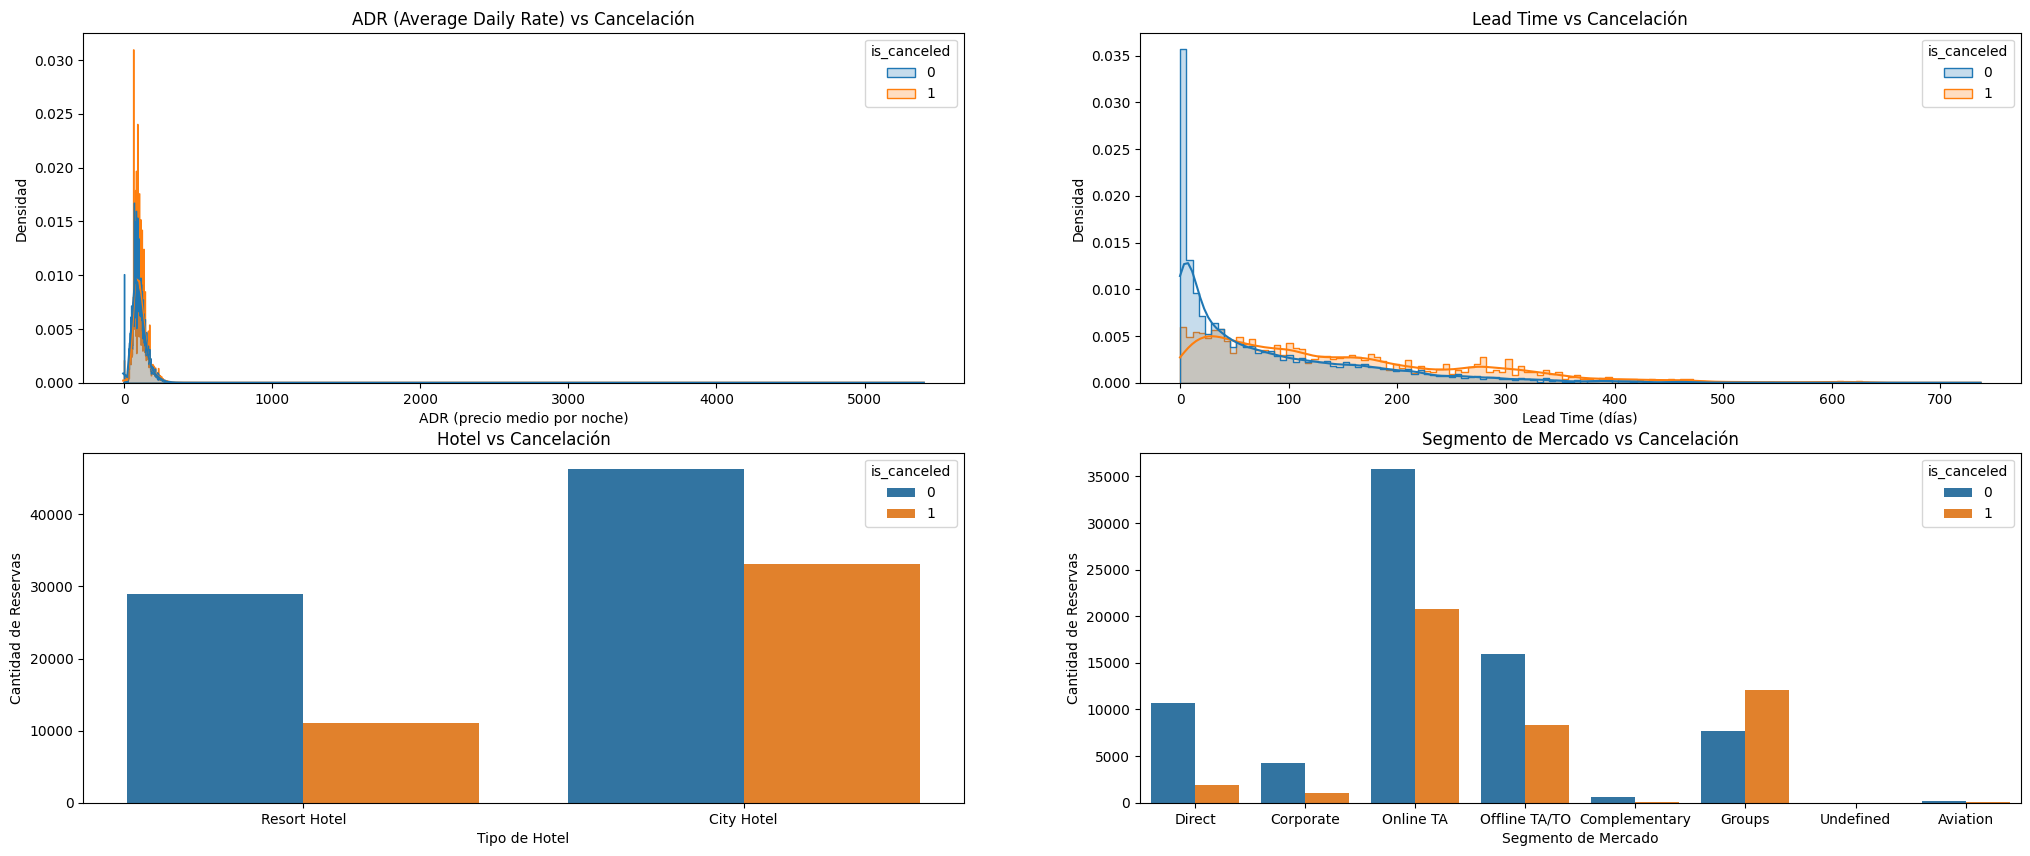

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

_, axis = plt.subplots(2, 2, figsize=(25, 10))

# 1. adr vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='adr', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 0]).set(
    title='ADR (Average Daily Rate) vs Cancelación',
    xlabel='ADR (precio medio por noche)',
    ylabel='Densidad',
)
# plt.xlim(0, 500)  # Limitar para que los outliers extremos no deformen el gráfico
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 2. lead_time vs. cancelación (histograma)
sns.histplot(data=df_hotel, x='lead_time', hue='is_canceled', kde=True, element="step", stat="density", common_norm=False, ax=axis[0, 1]).set(
    title='Lead Time vs Cancelación',
    xlabel='Lead Time (días)',
    ylabel='Densidad',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 3. hotel vs. cancelación
sns.countplot(data=df_hotel, x='hotel', hue='is_canceled', ax=axis[1, 0]).set(
    title='Hotel vs Cancelación',
    xlabel='Tipo de Hotel',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])


# 4. market_segment vs. cancelación
sns.countplot(data=df_hotel, x='market_segment', hue='is_canceled', ax=axis[1, 1]).set(
    title='Segmento de Mercado vs Cancelación',
    xlabel='Segmento de Mercado',
    ylabel='Cantidad de Reservas',
)
# plt.legend(title='Cancelada', labels=['No', 'Sí'])
# plt.xticks(rotation=45)


plt.show()

### Matriz de correlación entre las variables numéricas

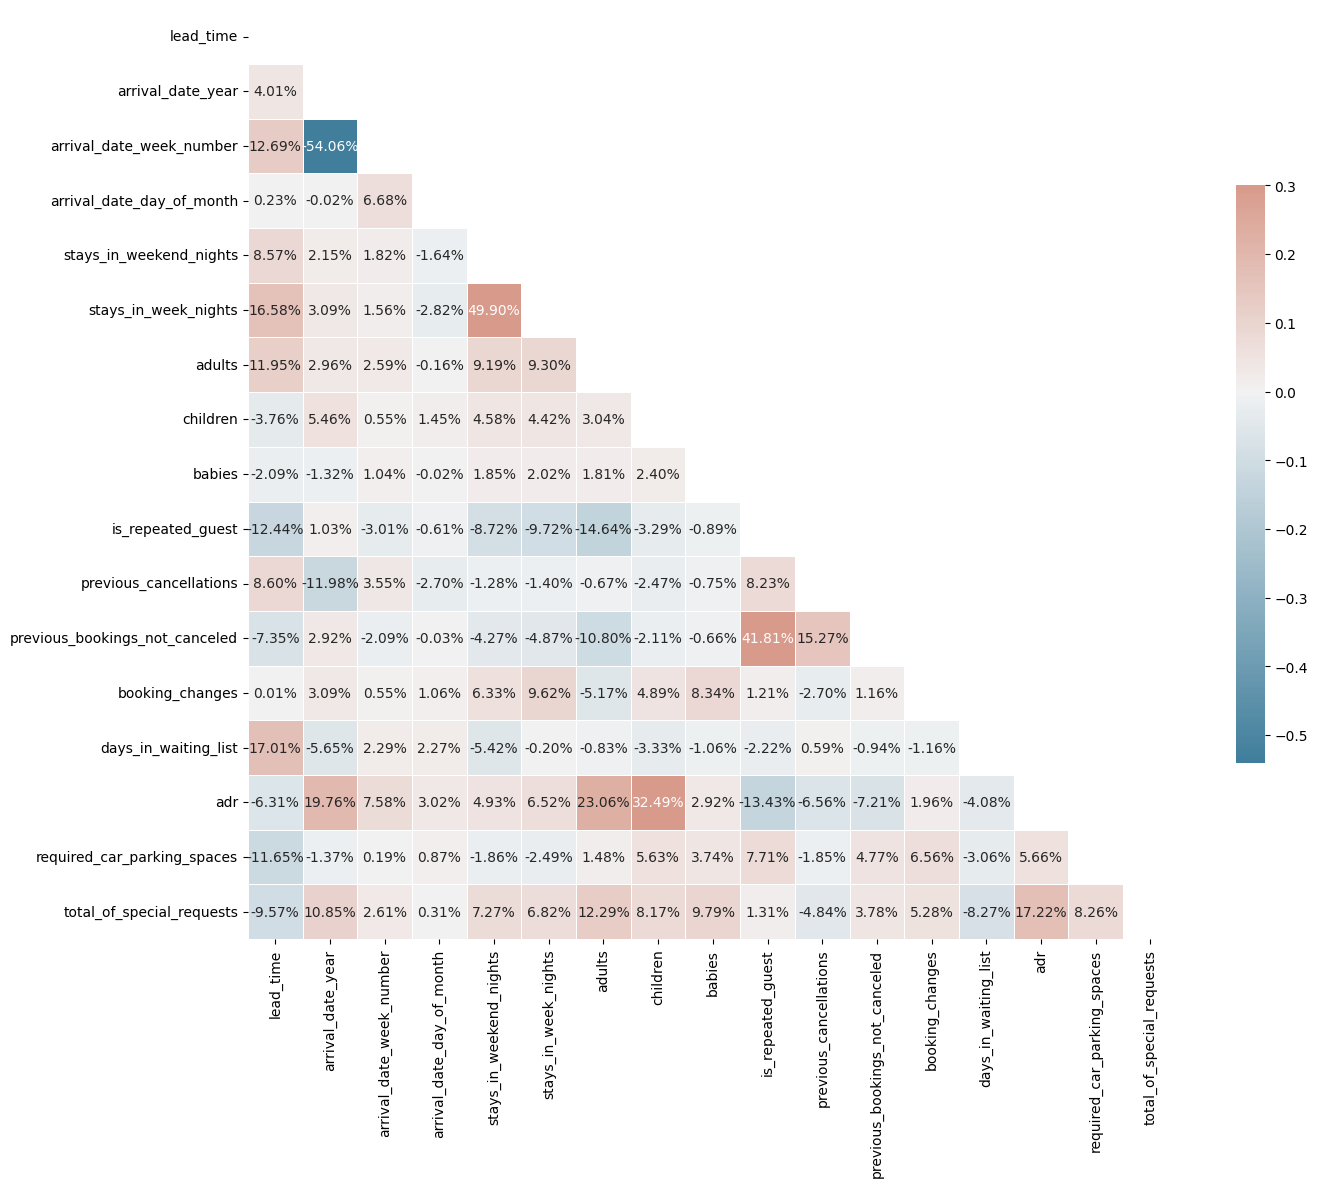

In [14]:


# crea la matriz de correlacion de las variables numericas
corr = df_hotel[col_numericas].corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlación entre las variables categoricas

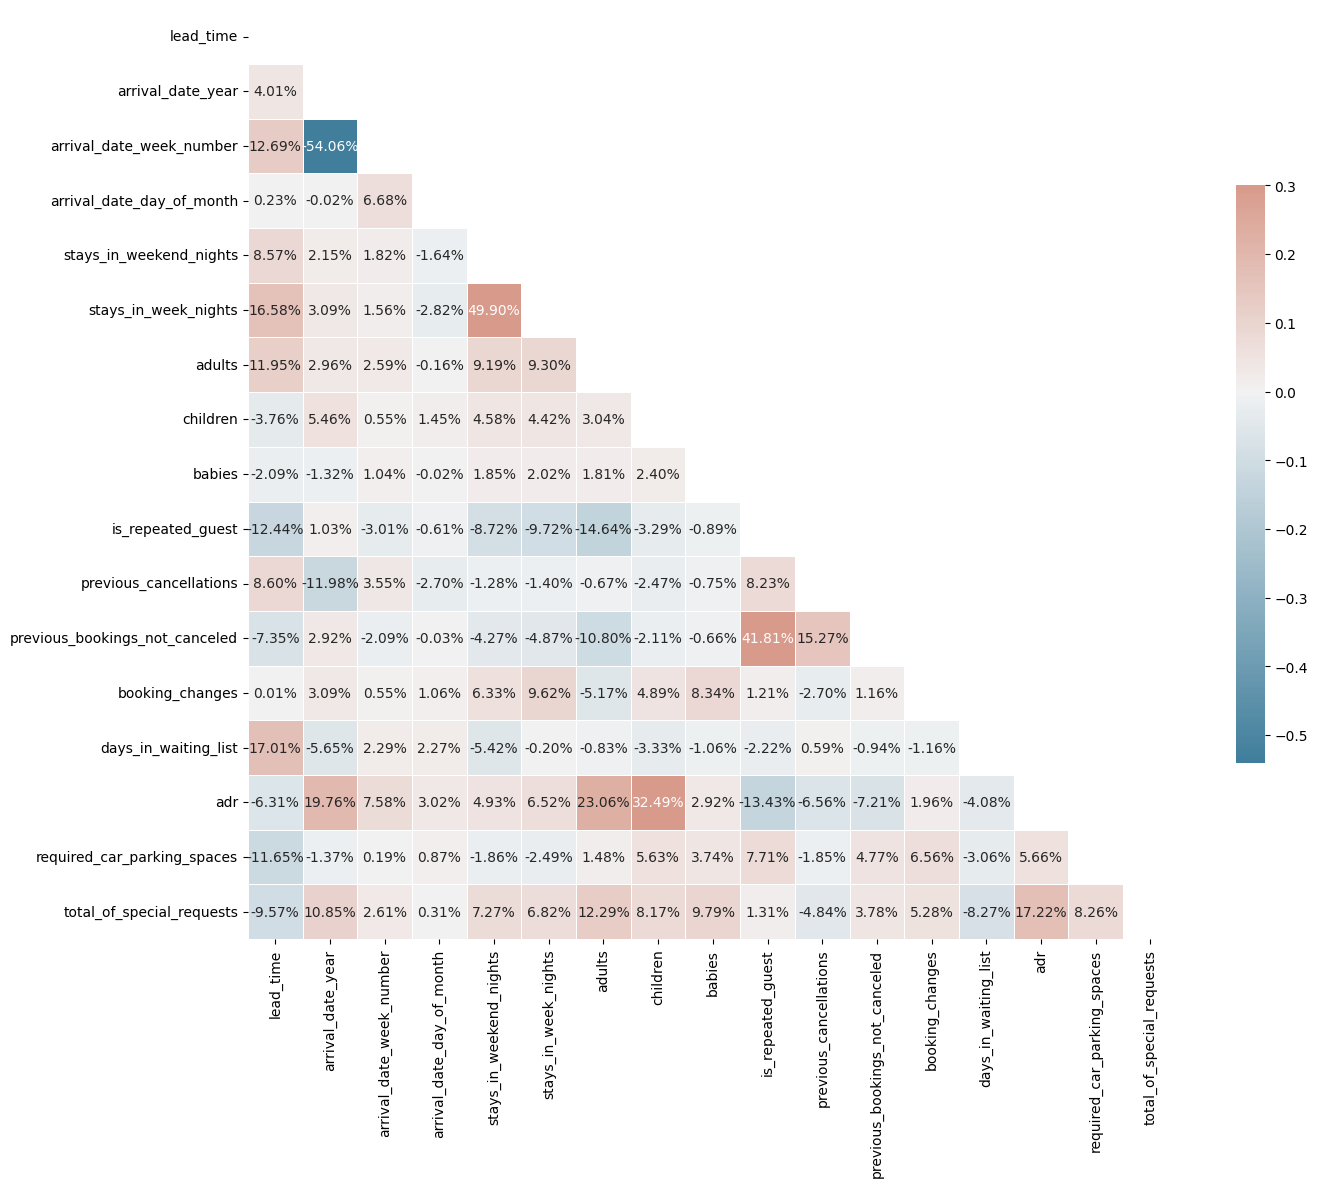

In [16]:
from sklearn.preprocessing import LabelEncoder


# convertimos las variables categoricas a numericas usnado sklearn
df_hotel_encoded = df_hotel.copy()
label_encoders = {}

for column in col_categoricas:
    # crea el decoder
    le = LabelEncoder()

    # hacemos ajuste y tranformacion de la columna
    df_hotel_encoded[column] = le.fit_transform(df_hotel[column])

    # guardamos el encoder por si luego queremos invertir
    label_encoders[column] = le

# crea la matriz de correlacion de las variables categoricas
corr = df_hotel_encoded[col_numericas].corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(15, 15))

### Matriz de correlacion completa de todas las variables

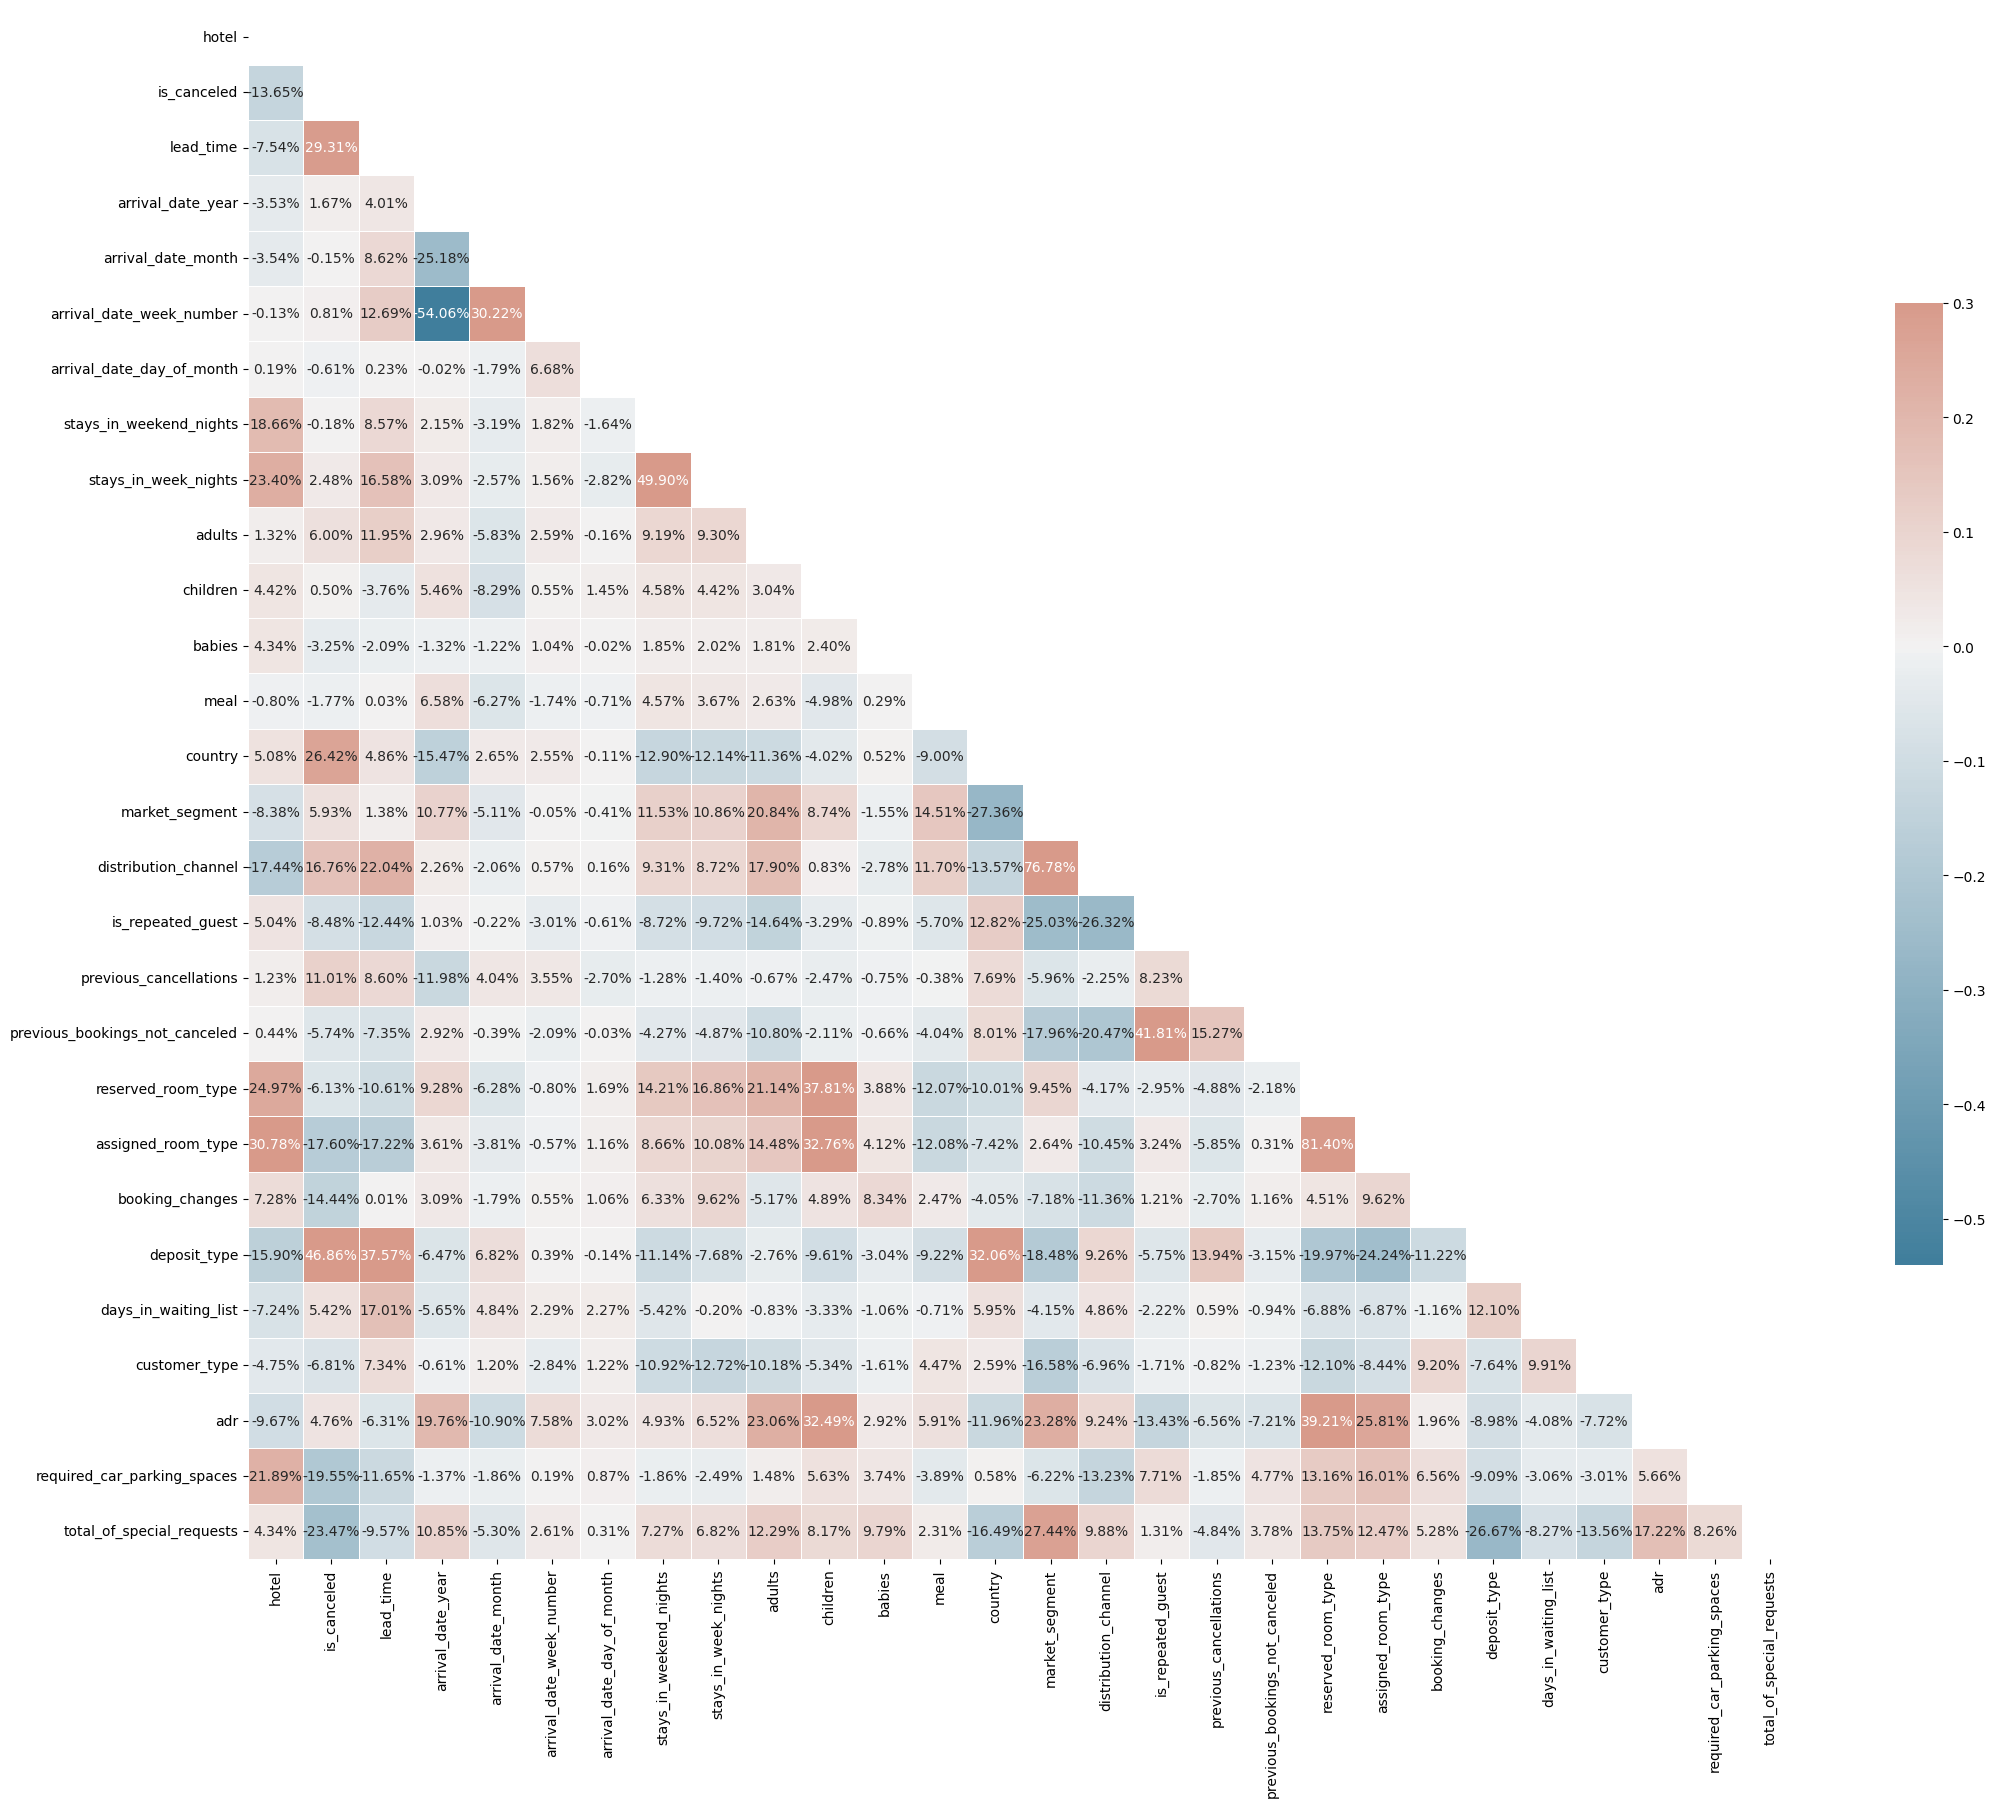

In [17]:
# crea la matriz de correlacion de todas las variables
corr = df_hotel_encoded.corr()

# dibuja la matriz de correlacion
draw_corr_matrix(corr=corr, fig_size=(25, 25))

A traves de estas matrices podemos hacer un analisis inicial, pero las decisiones sobre qué variables tomar y sacar se hara más adelante en el analisis del modelo.

In [18]:
# set independent and dependent variables
X: pd.DataFrame = df_hotel.drop(target, axis=1)
y: pd.Series = df_hotel[target]

# divide the dataset into training and test samples
X_train, X_test, y_train, y_test = split_my_data(X, y, test_size=0.2, random_state=42)

In [19]:
# constants for file paths
# path to save the processed data
X_TRAIN_PATH: str = "../data/processed/x_train.csv"
X_TEST_PATH: str = "../data/processed/x_test.csv"

Y_TRAIN_PATH: str = "../data/processed/y_train.csv"
Y_TEST_PATH: str = "../data/processed/y_test.csv"


In [20]:
X_train.to_csv(path_or_buf=X_TRAIN_PATH, sep=',', index=False, )
X_test.to_csv(path_or_buf=X_TEST_PATH, sep=',', index=False, )


y_train.to_csv(path_or_buf=Y_TRAIN_PATH, sep=',', index=False, )
y_test.to_csv(path_or_buf=Y_TEST_PATH, sep=',', index=False, )